<a href="https://colab.research.google.com/github/AmanPawar9/Debries-Flow-Prediction-using-ANN/blob/main/ann_for_debris_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
 
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


**mounting gdrive**

In [ ]:
!ls

 LL.csv		        Map_ploting.csv   Susceptability_Tiff.tif
 Main_output.csv        my_model.h5	 'Training and Testing data.csv'
'Map_ploting (1).csv'   Predictions.csv   weights


In [ ]:
%cd /content/gdrive/MyDrive/Colab Notebooks/IES/ANN

/content/gdrive/MyDrive/Colab Notebooks/IES/ANN


In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import sklearn
from sklearn.metrics import confusion_matrix
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental.preprocessing import Normalization
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['figure.figsize'] = (8,12)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [ ]:
tf.__version__


'2.5.0'

In [ ]:
!ls

 LL.csv		        Map_ploting.csv   Susceptability_Tiff.tif
 Main_output.csv        my_model.h5	 'Training and Testing data.csv'
'Map_ploting (1).csv'   Predictions.csv   weights


In [ ]:
dataframe = pd.read_csv('Training_and_Testing_data.csv')
dataframe.shape

FileNotFoundError: ignored

In [ ]:
!ls


'Training and Testing data.csv'   vertopal.com_Code.ipynb


In [ ]:
dataframe = pd.read_csv('Training and Testing data.csv')
dataframe.shape

(1109, 10)

In [ ]:
dataframe.head()

,OBJECTID,Debris,Aspect,dist_drain,Fac,NDVI,slope_deg,Elevation,TPI_Index,TWI_Index
0,1,0,235.5390,424.264,246,0.014274,28.32220,4396,-1.045380,9.48417
1,2,0,148.5700,6207.100,8,-0.008422,10.41490,5846,0.064828,7.24776
2,3,0,259.9920,1972.030,1,-0.001264,8.55379,5466,-0.139504,5.94417
3,4,0,322.9430,4714.580,1,-0.038678,28.14610,5391,0.524576,4.67530
4,5,0,31.6075,1772.290,0,-0.015655,7.57583,4977,-0.769529,5.37405


In [ ]:
dataframe = dataframe.drop('OBJECTID', axis=1)

In [ ]:
dataframe.head()

,Debris,Aspect,dist_drain,Fac,NDVI,slope_deg,Elevation,TPI_Index,TWI_Index
0,0,235.5390,424.264,246,0.014274,28.32220,4396,-1.045380,9.48417
1,0,148.5700,6207.100,8,-0.008422,10.41490,5846,0.064828,7.24776
2,0,259.9920,1972.030,1,-0.001264,8.55379,5466,-0.139504,5.94417
3,0,322.9430,4714.580,1,-0.038678,28.14610,5391,0.524576,4.67530
4,0,31.6075,1772.290,0,-0.015655,7.57583,4977,-0.769529,5.37405


In [ ]:
val_dataframe = dataframe.sample(frac=0.3, random_state=1001)
train_dataframe = dataframe.drop(val_dataframe.index)

print("Using %d samples for training and %d for validation" % (len(train_dataframe), len(val_dataframe)))

Using 776 samples for training and 333 for validation


In [ ]:
train_dataframe.head()

,Debris,Aspect,dist_drain,Fac,NDVI,slope_deg,Elevation,TPI_Index,TWI_Index
0,0,235.5390,424.264,246,0.014274,28.32220,4396,-1.045380,9.48417
1,0,148.5700,6207.100,8,-0.008422,10.41490,5846,0.064828,7.24776
2,0,259.9920,1972.030,1,-0.001264,8.55379,5466,-0.139504,5.94417
3,0,322.9430,4714.580,1,-0.038678,28.14610,5391,0.524576,4.67530
4,0,31.6075,1772.290,0,-0.015655,7.57583,4977,-0.769529,5.37405


In [ ]:
def dataframe_to_dataset(dataframe, shuffle=False, batch_size=32):
    dataframe = dataframe.copy()
    labels = dataframe.pop('Debris')
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)
    return ds

In [ ]:
# verification of dataset object
batch_size = 2
train_ds = dataframe_to_dataset(train_dataframe, batch_size=batch_size)
[(train_features, label_batch)] = train_ds.take(1)

In [ ]:
train_features

{'Aspect': <tf.Tensor: shape=(2,), dtype=float64, numpy=array([235.539, 148.57 ])>,
 'Elevation': <tf.Tensor: shape=(2,), dtype=int64, numpy=array([4396, 5846])>,
 'Fac': <tf.Tensor: shape=(2,), dtype=int64, numpy=array([246,   8])>,
 'NDVI': <tf.Tensor: shape=(2,), dtype=float64, numpy=array([ 0.0142738 , -0.00842192])>,
 'TPI_Index': <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-1.04538  ,  0.0648285])>,
 'TWI_Index': <tf.Tensor: shape=(2,), dtype=float64, numpy=array([9.48417, 7.24776])>,
 'dist_drain': <tf.Tensor: shape=(2,), dtype=float64, numpy=array([ 424.264, 6207.1  ])>,
 'slope_deg': <tf.Tensor: shape=(2,), dtype=float64, numpy=array([28.3222, 10.4149])>}

In [ ]:
label_batch


<tf.Tensor: shape=(2,), dtype=int64, numpy=array([0, 0])>

In [ ]:
# verification of dataset object
train_ds = dataframe_to_dataset(train_dataframe, batch_size=64)
val_ds = dataframe_to_dataset(val_dataframe, batch_size=64)

Pre-processing¶
Normalizing all numerical inputs


In [ ]:
# to mean 0 and std 1
def encode_numerical_feature(feature, name, dataset):
    normalizer = Normalization()
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))
    normalizer.adapt(feature_ds)
    encoded_feature = normalizer(feature)
    return encoded_feature

In [ ]:
train_dataframe.head()


,Debris,Aspect,dist_drain,Fac,NDVI,slope_deg,Elevation,TPI_Index,TWI_Index
0,0,235.5390,424.264,246,0.014274,28.32220,4396,-1.045380,9.48417
1,0,148.5700,6207.100,8,-0.008422,10.41490,5846,0.064828,7.24776
2,0,259.9920,1972.030,1,-0.001264,8.55379,5466,-0.139504,5.94417
3,0,322.9430,4714.580,1,-0.038678,28.14610,5391,0.524576,4.67530
4,0,31.6075,1772.290,0,-0.015655,7.57583,4977,-0.769529,5.37405


In [ ]:
train_dataframe.columns

Index(['Debris', 'Aspect', 'dist_drain', 'Fac', 'NDVI', 'slope_deg',
       'Elevation', 'TPI_Index', 'TWI_Index'],
      dtype='object')

In [ ]:
Aspect = keras.Input(shape=(1,), name="Aspect")
dist_drain = keras.Input(shape=(1,), name="dist_drain")
Fac = keras.Input(shape=(1,), name="Fac")
NDVI = keras.Input(shape=(1,), name="NDVI")
slope_deg = keras.Input(shape=(1,), name="slope_deg")
Elevation = keras.Input(shape=(1,), name="Elevation")
TPI_Index = keras.Input(shape=(1,), name="TPI_Index")
TWI_Index = keras.Input(shape=(1,), name="TWI_Index")

all_inputs = [Aspect, dist_drain, Fac, NDVI, slope_deg, Elevation, TPI_Index, TWI_Index]

In [ ]:
Aspect_encoded = encode_numerical_feature(Aspect, "Aspect", train_ds)
dist_drain_encoded = encode_numerical_feature(dist_drain, "dist_drain", train_ds)
Fac_encoded = encode_numerical_feature(Fac, "Fac", train_ds)
NDVI_encoded = encode_numerical_feature(NDVI, "NDVI", train_ds)
slope_deg_encoded = encode_numerical_feature(slope_deg, "slope_deg", train_ds)
Elevation_encoded = encode_numerical_feature(Elevation, "Elevation", train_ds)
TPI_Index_encoded = encode_numerical_feature(TPI_Index, "TPI_Index", train_ds)
TWI_Index_encoded = encode_numerical_feature(TWI_Index, "TWI_Index", train_ds)

all_features = layers.concatenate([Aspect_encoded, dist_drain_encoded, Fac_encoded, 
                                    NDVI_encoded, slope_deg_encoded, Elevation_encoded,
                                    TPI_Index_encoded, TWI_Index_encoded])

**Model training**

In [ ]:
x = layers.Dense(32, activation="relu")(all_features)
x = layers.Dense(32, activation="relu")(x)
x = layers.Dense(32, activation="relu")(x)
x = tf.keras.layers.Dropout(0.1)(x)
output = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(all_inputs, output)
'''
model.compile("adam", "binary_crossentropy", 
              metrics=["accuracy",
                       tf.keras.metrics.AUC(name='auc'),
                       keras.metrics.TruePositives(name='tp'),
                       keras.metrics.FalsePositives(name='fp'),
                       keras.metrics.TrueNegatives(name='tn'),
                       keras.metrics.FalseNegatives(name='fn')
                      ])
                      '''
model.compile("adam", "binary_crossentropy", 
              metrics=["accuracy",
                       tf.keras.metrics.AUC(name='auc')
                      ])

In [ ]:
model.summary()



Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Aspect (InputLayer)             [(None, 1)]          0                                            
__________________________________________________________________________________________________
dist_drain (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
Fac (InputLayer)                [(None, 1)]          0                                            
__________________________________________________________________________________________________
NDVI (InputLayer)               [(None, 1)]          0                                            
______________________________________________________________________________________________

In [ ]:
history = model.fit(train_ds, epochs=40, validation_data=val_ds)


Epoch 1/40
13/13 [==============================] - 2s 35ms/step - loss: 0.5882 - accuracy: 0.8827 - auc: 0.2507 - val_loss: 0.4481 - val_accuracy: 0.9189 - val_auc: 0.4535
Epoch 2/40
13/13 [==============================] - 0s 6ms/step - loss: 0.4636 - accuracy: 0.8943 - auc: 0.4576 - val_loss: 0.3792 - val_accuracy: 0.9189 - val_auc: 0.5839
Epoch 3/40
13/13 [==============================] - 0s 5ms/step - loss: 0.4009 - accuracy: 0.8943 - auc: 0.5973 - val_loss: 0.3319 - val_accuracy: 0.9189 - val_auc: 0.6792
Epoch 4/40
13/13 [==============================] - 0s 5ms/step - loss: 0.3592 - accuracy: 0.8943 - auc: 0.6609 - val_loss: 0.3005 - val_accuracy: 0.9189 - val_auc: 0.7394
Epoch 5/40
13/13 [==============================] - 0s 5ms/step - loss: 0.3319 - accuracy: 0.8943 - auc: 0.7221 - val_loss: 0.2806 - val_accuracy: 0.9189 - val_auc: 0.7767
Epoch 6/40
13/13 [==============================] - 0s 5ms/step - loss: 0.3097 - accuracy: 0.8943 - auc: 0.7677 - val_loss: 0.2662 - val_ac

In [ ]:
history.history.keys()


dict_keys(['loss', 'accuracy', 'auc', 'val_loss', 'val_accuracy', 'val_auc'])

In [ ]:
def plot_metrics(history):
    metrics = ['loss', 'accuracy']
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(3,1,n+1)
        plt.plot(history.epoch, history.history[metric], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric],
                 linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        
        plt.legend()

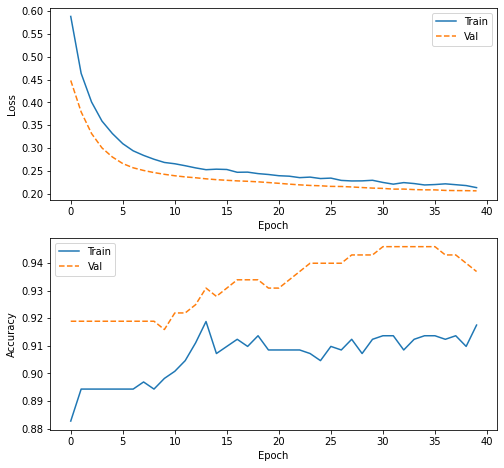

In [ ]:
plot_metrics(history)


In [ ]:
print(model.evaluate(val_ds))


6/6 [==============================] - 0s 3ms/step - loss: 0.2065 - accuracy: 0.9369 - auc: 0.8644
[0.2065228372812271, 0.9369369149208069, 0.8643791079521179]


**Save model weights**


In [ ]:
model.save("weights")


INFO:tensorflow:Assets written to: weights/assets


INFO:tensorflow:Assets written to: weights/assets


In [ ]:
test_ds = dataframe_to_dataset(val_dataframe, batch_size=333) # shuffle is False


In [ ]:
test_predictions = model.predict(test_ds).ravel()
test_predictions.shape

(333,)

In [ ]:
test_labels = val_dataframe['Debris']
test_labels.shape

(333,)

In [ ]:
fpr, tpr, thresholds = sklearn.metrics.roc_curve(test_labels, test_predictions)

In [ ]:
auc_score = sklearn.metrics.auc(fpr,tpr)
auc_score

0.8672234325829097

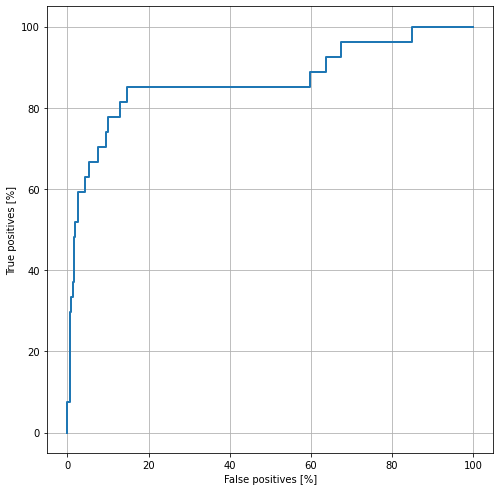

In [ ]:
plt.plot(100*fpr, 100*tpr, linewidth=2)
plt.xlabel('False positives [%]')
plt.ylabel('True positives [%]')
plt.grid(True)
ax = plt.gca()
ax.set_aspect('equal')

Write the output file

In [ ]:
val_dataframe.head()

,Debris,Aspect,dist_drain,Fac,NDVI,slope_deg,Elevation,TPI_Index,TWI_Index
192,0,66.3179,1380.3300,0,-0.016411,28.4716,5042,-0.616279,3.96855
474,0,60.1240,3167.2400,0,-0.002039,25.2803,3831,0.051206,4.10683
205,0,49.7636,4331.0300,3,-0.011887,20.3521,5564,-0.285942,5.73463
951,0,36.8699,2773.3400,2,-0.016797,31.3796,5861,0.984324,4.94969
1059,1,138.1480,84.8528,122,0.193095,50.9814,2211,-2.404190,7.95850


In [ ]:
val_dataframe['Predictions'] = test_predictions

NameError: ignored

In [ ]:
val_dataframe.head()

,Debris,Aspect,dist_drain,Fac,NDVI,slope_deg,Elevation,TPI_Index,TWI_Index,Predictions
192,0,66.3179,1380.3300,0,-0.016411,28.4716,5042,-0.616279,3.96855,0.097050
474,0,60.1240,3167.2400,0,-0.002039,25.2803,3831,0.051206,4.10683,0.041140
205,0,49.7636,4331.0300,3,-0.011887,20.3521,5564,-0.285942,5.73463,0.002610
951,0,36.8699,2773.3400,2,-0.016797,31.3796,5861,0.984324,4.94969,0.002347
1059,1,138.1480,84.8528,122,0.193095,50.9814,2211,-2.404190,7.95850,0.506843


In [ ]:
val_dataframe.to_csv("Predictions.csv")

NameError: ignored